In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

In [3]:
import torch

In [ ]:
geno = io_utils.loadGenotypes(
    '/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/monocyte_pool.vcf.gz.gz',
    maxlines = None, 
    posterior = False,
    print_every = 1e5,
    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
geno.reset_index().to_feather('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/monocyte_pool.feather')

In [4]:
geno = io_utils.loadGenotypes(
    '/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/merged_ancestries_microglia.vcf.gz',
    maxlines = None, 
    posterior = False,
    print_every = 1e5,
    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
geno.reset_index().to_feather('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather')

In [5]:
geno

,position,contig,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,GSA8_0_RAJBrain_NPBB319,GSA8_0_RAJBrain_NPBB312,GSA8_0_RAJBrain_NPBB334,GSA8_0_RAJBrain_NPBB324,GSA8_0_RAJBrain_NPBB305,GSA8_0_RAJBrain_NPBB333,GSA8_0_RAJBrain_NPBB308,GSA8_0_RAJBrain_NPBB316,GSA8_0_RAJBrain_NPBB331
chr1:11171:CCTTG:C,11171,chr1,chr1:11171:CCTTG:C,CCTTG,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
chr1:23197:TTAAAA:T,23197,chr1,chr1:23197:TTAAAA:T,TTAAAA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
chr1:48824:T:C,48824,chr1,chr1:48824:T:C,T,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
chr1:54490:G:A,54490,chr1,chr1:54490:G:A,G,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22:50805809:C:T,50805809,chr22,chr22:50805809:C:T,C,T,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
chr22:50806269:TGAA:T,50806269,chr22,chr22:50806269:TGAA:T,TGAA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
chr22:50806436:A:C,50806436,chr22,chr22:50806436:A:C,A,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
chr22:50806802:G:A,50806802,chr22,chr22:50806802:G:A,G,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN


In [20]:
geno[(geno.contig == "chr3" ) & (geno.position == 106054211)]

,position,contig,variantID,refAllele,altAllele,GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,...,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01


In [19]:
geno = pd.read_feather("/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/monocyte_pool.feather")
del geno['index']
geno.head()

,position,contig,variantID,refAllele,altAllele,GSA6_54_NYUMD0149-01,GSA6_8_NYUMD0179-01,GSA6_112_BIMD0195-01,GSA3-PD3_176_NYUMD0079-01,GSA4_6_NYUMD0117-01,...,GSA8_0_NYUMD0280-01,GSA8_0_NYUMD0327-01,GSA3-PD3_209_NYUMD0041-01,GSA6_19_NYUMD0189-01,GSA6_80_NYUMD0163-01,GSA7_316_NYUMD0231,GSA4_78_NYUMD0087,GSA6_13_NYUMD0156-01,GSA5_16_NYUMD0075-01,GSA8_0_NYUMD0296-01
0,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,409458,chr1,chr1:409458:T:TTATTTA,T,TTATTTA,0.5,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,595259,chr1,chr1:595259:G:A,G,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,701203,chr1,chr1:701203:G:T,G,T,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,708118,chr1,chr1:708118:TCAC:T,TCAC,T,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
monocytes_counts_files = list(sorted(Path('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes').glob('*allelic_out.txt')))
monocytes_counts_files

[PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CEBPB_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CTCF_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/H3K27ac_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/MEF2C_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/PU1_mono_allelic_out.txt')]

In [4]:
tfs = [x.name.split("_")[0] for x in monocytes_counts_files]
tfs

NameError: name 'monocytes_counts_files' is not defined

In [5]:
def read_counts(counts_file):
     return pd.read_csv(counts_file,
                        sep = "\t",
                        usecols = range(8),
                        index_col = False)

In [6]:
import importlib
import gc
importlib.reload(deconvolve)

<module 'pooledQTL.deconvolve' from '/home/dmeyer/projects/poolqtl/src/pooledQTL/deconvolve.py'>

In [16]:
gc.collect()

9764

In [15]:
counts_files = monocytes_counts_files
for i in range(len(counts_files)):
    counts_file = monocytes_counts_files[i]
    tf = str(counts_file).split('/')[-1].strip('_mono_allelic.out.txt')
    print(f"{i+1} out of {len(counts_files)}\t{tf}", end="\r")
    w = deconvolve.deconvolve(
        geno, 
        read_counts(counts_file), 
        sample_inds = range(5, geno.shape[1]), 
        total_thres = 30, 
        plot = False,
        outfile = f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/QC_plots/Monocytes_{tf}.jpg",
        plot_title = f"Monocytes {tf} deconvolution / QC plots",
        save_data = f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Monocytes_{tf}.combined_data.txt"
    )
    pd.DataFrame({"cell_line": geno.columns[range(5, geno.shape[1])], "estimated_representation" : w}).to_csv(
         f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Monocytes_{tf}.deconvolution.txt",
        sep = "\t", index = False)
    del w
    gc.collect()

### detour

In [39]:
monocytes_counts_files

[PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CEBPB_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/CTCF_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/H3K27ac_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/MEF2C_mono_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Monocytes/PU1_mono_allelic_out.txt')]

In [200]:
dat=read_counts(monocytes_counts_files[0])
# join genotype data and input allele counts
merged = geno.merge(dat, on = ["variantID", "refAllele", "altAllele"]) # should we also join on contig? 

In [201]:
sample_inds = range(5, geno.shape[1])
total_thres = 10

In [202]:
# consider different defitions of ref vs alt
geno_flip = geno.rename(columns={"altAllele" : "refAllele", "refAllele":"altAllele"})

In [203]:
import gc

In [204]:
geno_flip.iloc[:,sample_inds] = 1. - geno_flip.iloc[:,sample_inds]
merged_flip = geno_flip.merge(dat, on = ["variantID", "refAllele", "altAllele"])
del geno_flip
gc.collect()

142302

In [205]:
combined = pd.concat((merged,merged_flip), axis=0) # this handles the misordering of alt/ref correctly
del merged_flip
gc.collect()

0

In [207]:
# remove any rows with missigness genotypes
to_keep = np.isnan(combined.iloc[:,sample_inds]).mean(1) == 0. # keep 96%

In [44]:
combined = combined[to_keep].copy()
combined.reset_index(drop=True, inplace=True)

combined["allelic_ratio"] = combined.altCount / combined.totalCount

# only perform deconv using SNPs with >total_thres total counts
comb_sub = combined[combined.totalCount >= total_thres].copy()

X = comb_sub.iloc[:,sample_inds].to_numpy() # dosage matrix
y = comb_sub.allelic_ratio.to_numpy() # observed allelic proportions
del comb_sub
gc.collect()

0

In [45]:
from sklearn.linear_model import LinearRegression
reg_nnls = LinearRegression(positive=True, fit_intercept=False)
reg_nnls.fit(X, y)
w = reg_nnls.coef_

In [46]:
X.shape[0]

83152

[Text(0.5, 0, '# of reads observed with SNP'),
 Text(0, 0.5, '# of SNPs'),
 Text(0.5, 1.0, '28,753 SNPs with >= 10 reads per SNP')]

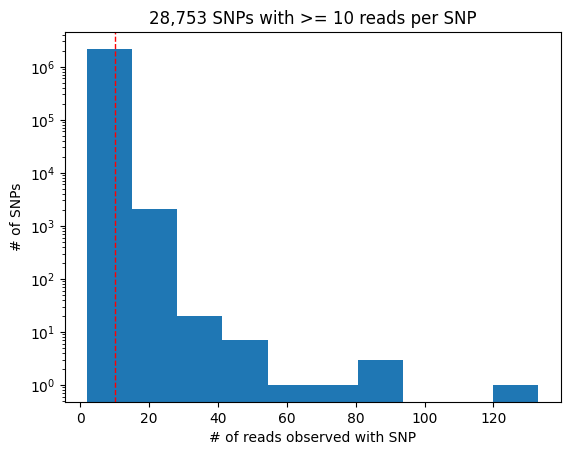

In [25]:
fig, ax3 = plt.subplots(1,1)
n_keep = np.sum(combined.totalCount > total_thres)
ax3.hist(combined.totalCount, log=True)
ax3.axvline(x=total_thres, color='r', linestyle='dashed', linewidth=1)
ax3.set(xlabel = "# of reads observed with SNP", ylabel = "# of SNPs",
                   title = f"{n_keep:,} SNPs with >= {total_thres} reads per SNP")
 

In [ ]:
geno.

In [ ]:
X.shape

[Text(0.5, 0, 'MAF in village'),
 Text(0, 0.5, '# of SNPs'),
 Text(0.5, 1.0, '6,283,754 SNPs with MAF > 0.05')]

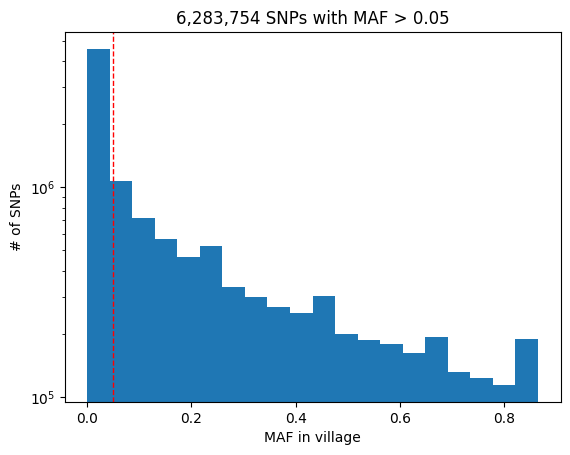

In [38]:
maf_thresh = 0.05
fig, ax4 = plt.subplots(1,1)
#n_keep = np.sum(geno.totalCount > total_thres)
maf = np.sum(geno.iloc[:,5:geno.shape[1]], axis=1) / geno.shape[1]
ax4.hist(maf, log=True, bins = 20)
ax4.axvline(x=maf_thresh, color='r', linestyle='dashed', linewidth=1)
ax4.set(xlabel = "MAF in village", ylabel = "# of SNPs", title=f"{np.sum(maf > maf_thresh):,} SNPs with MAF > {maf_thresh}")

In [140]:
import torch
torch_matmul = lambda x,y : (torch.tensor(x) @ torch.tensor(y)).numpy() # do we need this? apparently yes!?
combined["pred"] = torch_matmul(combined.iloc[:,sample_inds].to_numpy(), w)

[Text(0.5, 0, 'Cell line'), Text(0, 0.5, '% representation in sample')]

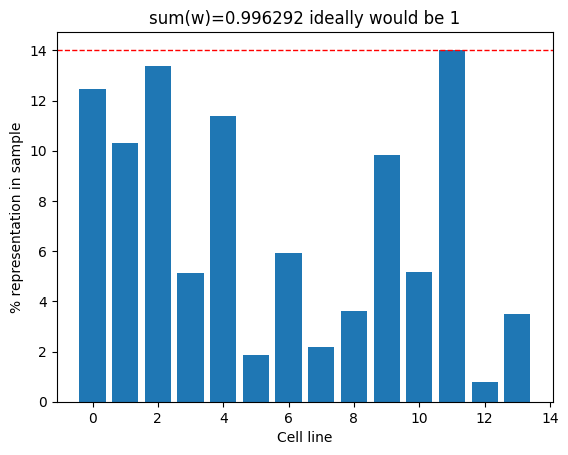

In [25]:
fig, ax1 = plt.subplots(1,1)
ax1.set_title("sum(w)=%f ideally would be 1" % w.sum())
ax1.bar(x = range(len(w)), height=w*100)
ax1.axhline(y=len(sample_inds), color='r', linestyle='dashed', linewidth=1) # red line showing uniform distr
ax1.set(xlabel="Cell line", ylabel="% representation in sample")

In [141]:
n_keep = np.sum(combined[combined.totalCount > total_thres].totalCount)

[Text(0.5, 0, 'Predicted allelic ratio from genotype'),
 Text(0, 0.5, 'Observed allelic ratio in input')]

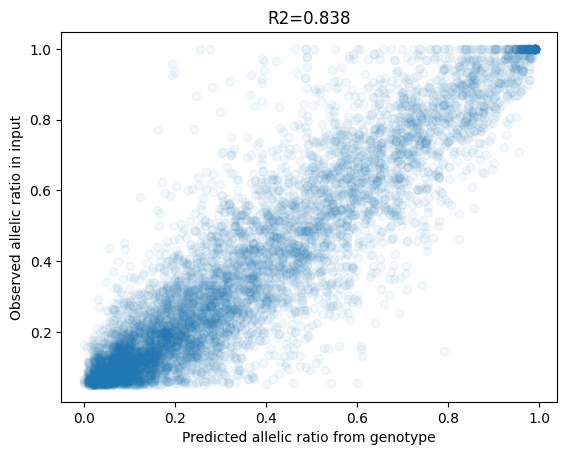

In [142]:
fig, ax2 = plt.subplots(1,1)
combined_30 = combined.loc[(combined.totalCount >= 30) & (combined.allelic_ratio >= 0.05),:]
corr,_ = scipy.stats.pearsonr(combined_30.pred, combined_30.allelic_ratio)
R2 = corr*corr

ax2.scatter(combined_30.pred, combined_30.allelic_ratio, alpha = 0.05)
ax2.set_title("R2=%.3f" % R2)
ax2.set(xlabel="Predicted allelic ratio from genotype", ylabel="Observed allelic ratio in input")

In [143]:
any(np.isnan(combined_30.iloc[:,sample_inds].sum(axis=0) / len(sample_inds)))

False

In [153]:
geno_ratio = combined_30.iloc[:,sample_inds].sum(axis=1) / len(sample_inds)

In [161]:
tmp = combined_30.reset_index()
tmp["geno_ratio"] =  geno_ratio.to_list()

In [167]:
sum(tmp[tmp.altCount == tmp.totalCount].geno_ratio >= .05)

218

(array([326408., 210502., 149220., 111875.,  89650.,  72273.,  60752.,
         51173.,  39625.,  25818.]),
 array([0.        , 0.09962923, 0.19925846, 0.29888769, 0.39851693,
        0.49814616, 0.59777539, 0.69740462, 0.79703385, 0.89666308,
        0.99629232]),
 <BarContainer object of 10 artists>)

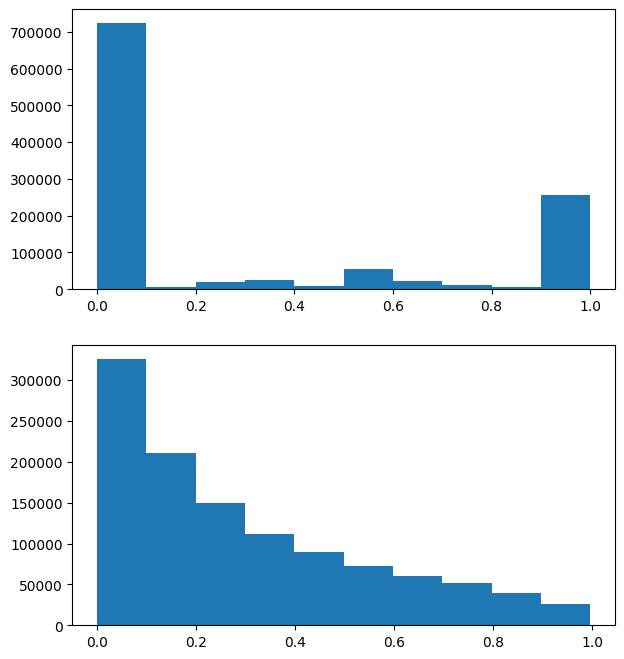

In [50]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,8))
ax1.hist(combined["allelic_ratio"])
ax2.hist(combined["pred"])

[Text(0.5, 0, 'Predicted allelic ratio from genotype'),
 Text(0, 0.5, 'Observed allelic ratio in input')]

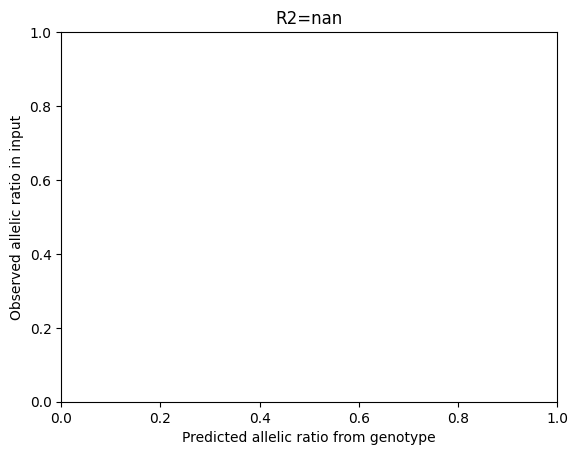

In [49]:
fig, ax2 = plt.subplots(1,1)

R2 = np.nan
if X.shape[0] > 0:
    combined_30 = combined[combined.totalCount >= 30]
    corr,_ = scipy.stats.pearsonr(combined_30.pred, combined_30.allelic_ratio)
    R2 = corr*corr
    ax2.scatter(combined_30.pred, combined_30.allelic_ratio, alpha = 0.05)
ax2.set_title("R2=%.3f" % R2)
ax2.set(xlabel="Predicted allelic ratio from genotype", ylabel="Observed allelic ratio in input")

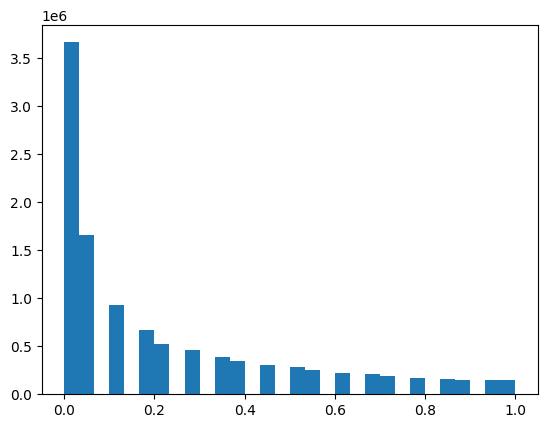

In [17]:
x = geno.iloc[:,5:].to_numpy()
maf = x.mean(1)
_ = plt.hist(maf,30)

In [ ]:
combined.

## Continue

In [6]:
import gc

In [23]:
del geno
gc.collect()

140491

In [ ]:
geno = pd.read_feather("/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather").set_index('index')
geno.head()

In [7]:
geno = pd.read_feather("/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather")
del geno['index']
geno.head()

,position,contig,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,GSA8_0_RAJBrain_NPBB319,GSA8_0_RAJBrain_NPBB312,GSA8_0_RAJBrain_NPBB334,GSA8_0_RAJBrain_NPBB324,GSA8_0_RAJBrain_NPBB305,GSA8_0_RAJBrain_NPBB333,GSA8_0_RAJBrain_NPBB308,GSA8_0_RAJBrain_NPBB316,GSA8_0_RAJBrain_NPBB331
0,11171,chr1,chr1:11171:CCTTG:C,CCTTG,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
1,23197,chr1,chr1:23197:TTAAAA:T,TTAAAA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,48824,chr1,chr1:48824:T:C,T,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,54490,chr1,chr1:54490:G:A,G,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [39]:
geno = io_utils.loadGenotypes(
    '/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/bgzipped_vcfs/merged_ancestries_microglia.vcf.gz',
    maxlines = None, 
    posterior = False,
    print_every = 1e5,
    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,GSA8_0_RAJBrain_NPBB306,GSA8_0_RAJBrain_NPBB307,GSA8_0_RAJBrain_NPBB310,GSA8_0_RAJBrain_NPBB314,GSA8_0_RAJBrain_NPBB318,GSA8_0_RAJBrain_NPBB319,GSA8_0_RAJBrain_NPBB312,GSA8_0_RAJBrain_NPBB334,GSA8_0_RAJBrain_NPBB324,GSA8_0_RAJBrain_NPBB305,GSA8_0_RAJBrain_NPBB333,GSA8_0_RAJBrain_NPBB308,GSA8_0_RAJBrain_NPBB316,GSA8_0_RAJBrain_NPBB331
chr1:11171:CCTTG:C,11171,chr1,chr1:11171:CCTTG:C,CCTTG,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
chr1:23197:TTAAAA:T,23197,chr1,chr1:23197:TTAAAA:T,TTAAAA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
chr1:23308:G:C,23308,chr1,chr1:23308:G:C,G,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
chr1:48824:T:C,48824,chr1,chr1:48824:T:C,T,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
chr1:54490:G:A,54490,chr1,chr1:54490:G:A,G,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [45]:
geno.reset_index().to_feather('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/VCF_files/feathers/merged_ancestries_microglia.feather')

In [8]:
microglia_counts_files = list(sorted(Path('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries').glob('*allelic_out.txt')))
microglia_counts_files

[PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/CEBPB_ALL_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/CTCF_ALL_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/H3K27ac_ALL_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/MEF2C_ALL_mic_allelic_out.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/SecondRound_bQTLs/Microglia_All_Ancestries/PU1_ALL_mic_allelic_out.txt')]

In [11]:
import gc

In [10]:
counts_files = microglia_counts_files
for i in range(len(counts_files)):
    counts_file = counts_files[i]
    tf = str(counts_file).split('/')[-1].split("_")[0]
    print(f"{i+1} out of {len(counts_files)}\t{tf}", end="\r")
    w = deconvolve.deconvolve(
        geno, 
        read_counts(counts_file), 
        sample_inds = range(5, geno.shape[1]), 
        total_thres = 30, 
        plot = False,
        outfile = f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/QC_plots/Microglia_All_Ancestries_{tf}.jpg",
        plot_title = f"Microglia all ancestries {tf} deconvolution / QC plots",
        save_data = f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Microglia_{tf}.combined_data.txt"
    )
    pd.DataFrame({"cell_line": geno.columns[range(5, geno.shape[1])], "estimated_representation" : w}).to_csv(
         f"/home/dmeyer/projects/bqtls/SecondRound_bQTLs/deconvolve_data/Microglia_{tf}.deconvolution.txt",
        sep = "\t", index = False)
    del w
    gc.collect()

In [18]:
geno_maf5 = geno.iloc[maf>=0.05,:]

sum(w)=0.910579 ideally would be 1


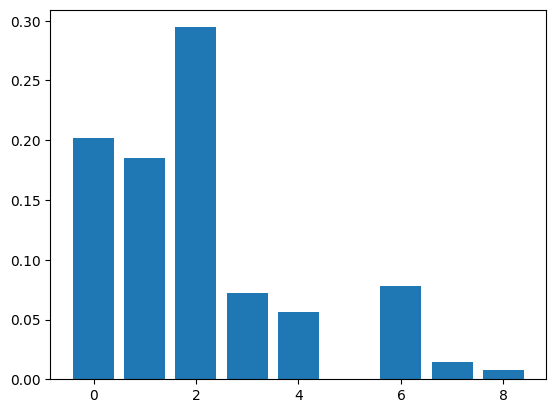

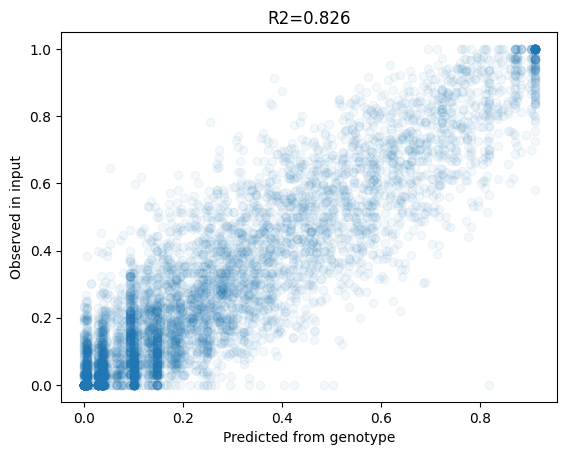

In [20]:
w = deconvolve.deconvolve(
    geno_maf5,
    counts, 
    sample_inds = range(5,14), 
    total_thres = 100, 
    plot = True
)

In [42]:
x = geno_maf5.iloc[:,5:].to_numpy()
maf = x.mean(1)

In [70]:
merged = geno_maf5.merge(counts, on = ["variantID", "refAllele", "altAllele", "contig", "position"]) # should we also join on contig? 


In [76]:
merged["maf"] = merged.iloc[:,5:15].to_numpy().mean(1)

Text(0, 0.5, 'AF in IP')

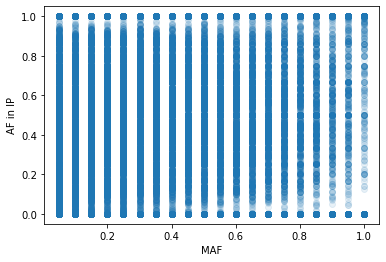

In [77]:
plt.scatter(merged.maf, merged.altCount / merged.totalCount, alpha = 0.1)
plt.xlabel("MAF")
plt.ylabel("AF in IP")

(array([9.14260e+04, 1.01183e+05, 0.00000e+00, 1.03654e+05, 9.60440e+04,
        1.45724e+05, 8.06540e+04, 4.03660e+04, 2.82870e+04, 1.43160e+04,
        1.25520e+04, 6.98900e+03, 6.10900e+03, 4.31100e+03, 3.69400e+03,
        2.70700e+03, 1.85800e+03, 1.44200e+03, 1.07200e+03, 7.50000e+02,
        5.45000e+02, 3.47000e+02, 2.47000e+02, 1.67000e+02, 8.80000e+01,
        5.30000e+01, 2.80000e+01, 6.00000e+00, 5.00000e+00, 3.00000e+00]),
 array([0.30103   , 0.39607194, 0.49111389, 0.58615583, 0.68119778,
        0.77623972, 0.87128167, 0.96632361, 1.06136556, 1.1564075 ,
        1.25144945, 1.34649139, 1.44153334, 1.53657528, 1.63161723,
        1.72665917, 1.82170111, 1.91674306, 2.011785  , 2.10682695,
        2.20186889, 2.29691084, 2.39195278, 2.48699473, 2.58203667,
        2.67707862, 2.77212056, 2.86716251, 2.96220445, 3.0572464 ,
        3.15228834]),
 <BarContainer object of 30 artists>)

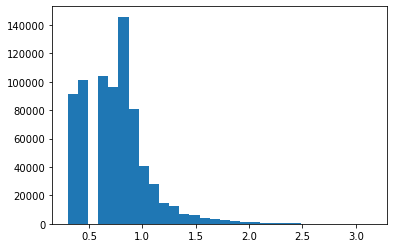

In [81]:
plt.hist(np.log10(merged.totalCount),30)

(array([80950.,   651.,   493.,   588.,   812.,  1267.,  1104.,  1280.,
         1692.,  1385.,  2250.,  1657.,  1246.,  1260.,   820.,   760.,
          769.,   329.,   573., 26056.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

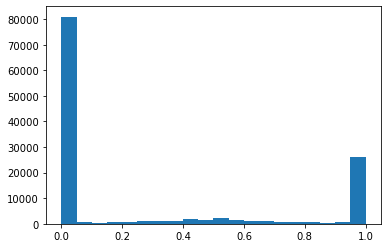

In [84]:
merged10 = merged[merged.totalCount >= 10]
plt.hist(merged10.altCount / merged10.totalCount, 20)

(125942, 19)

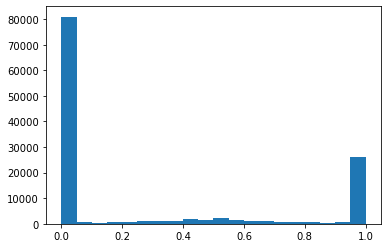

In [85]:
merged30 = merged[merged.totalCount >= 10]
plt.hist(merged30.altCount / merged30.totalCount, 20)
merged30.shape

In [66]:
(merged.totalCount > 100).sum()

3449

In [15]:
1 / 32

0.03125